In [2]:
import torch

# GPU 사용 가능 -> True, GPU 사용 불가 -> False
print(torch.cuda.is_available())

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

True


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns

In [2]:
from matplotlib import rc
import matplotlib.font_manager as fm

# fm._rebuild()
# fm.get_fontconfig_fonts()

# 디렉토리 및 파일 이름에 맞추어 변경
font_location = '../Jeju_product_price/font/NanumGothicBold.ttf'

font_name = fm.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)

## Dataset Info.

1. train.csv

 - train 데이터 : 2019년 01월 01일부터 2023년 03월 03일까지의 유통된 품목의 가격 데이터
 - item: 품목 코드
   - TG : 감귤
      - 극조생(9~11월 중순)
      - 조생(11월 중순~12월)
      - 만감류(12~5월)
   - BC : 브로콜리
      - 2∼3월 수확된 브로콜리는 저온저장을 하여 단경기인 4월 상순 ∼5월 상순까지 출하하고 있으며, 일부농가에서는 봄재배를 하여 4월 하순부터 5월 하순 까지 출하하고 있다.
   - RD : 무
      - 제주도 월동무는 8~9월에 파종하고 11월 중순부터 다음 해 4월까지 수확합니다. 한겨울에 수확해 겨우내 먹는 '겨울을 나는 무'라는 의미입니다. 
      - 제주도 내 전체 월동무 물량의 45%는 서귀포시 성산읍에서 생산됩니다. 성산읍의 겨울철 평균 기온인 6℃는 노지에서 동해 피해 없이 월동무가 자랄 수 있는 최적의 기온입니다. 
   - CR : 당근
      - 구좌와 성산지역이 주류를 이루고 있다. 이들 주산지의 당근재배는 7, 8월에 파종하여 11월부터 이듬해 2～3월까지 수확 하여 출아하는 작형으로 일시출하에 따른 가격하락의 한 원인이 되기도 한다.
   - CB : 양배추
      - 제주지역은 겨울에도 온난한 날씨 덕분에 노지에서 양배추와 당근, 무, 브로콜리를 재배·수확할 수 있다. 제주에서는 겨울철에 폭풍 성장한 이 작물을 '월동채소'라 부른다. 농민들은 지난해 8~9월 양배추 새싹(모종)을 심었다. 수확은 지난 2월 초부터 시작해 4월 말에 끝낸다
- corporation : 유통 법인 코드
    - 법인 A부터 F 존재
 - location : 지역 코드
   - J : 제주도 제주시
   - S : 제주도 서귀포시
- supply(kg) : 유통된 물량, kg 단위
- price(원/kg) : 유통된 품목들의 kg 마다의 가격, 원 단위


2. international_trade.csv

관련 품목 수출입 정보
중량 단위 kg
금액 단위 천 달러


3. test.csv

test 데이터 : 2023년 03월 04일부터 2023년 03월 31일까지의 데이터


4. sample_submission.csv

제출을 위한 양식
2023년 03월 04일부터 2023년 03월 31일까지의 price(원/kg)을 예측
ID는 품목, 유통 법인, 지역 코드로 구성된 식별자
해당 ID에 맞춰 price(원/kg) 예측값을 answer 컬럼에 기입해야 함


---

### train DataSet

In [3]:
train_df = pd.read_csv('../Jeju_product_price/data/train.csv')

## train Data 확인

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           59397 non-null  object 
 1   timestamp    59397 non-null  object 
 2   item         59397 non-null  object 
 3   corporation  59397 non-null  object 
 4   location     59397 non-null  object 
 5   supply(kg)   59397 non-null  float64
 6   price(원/kg)  59397 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.2+ MB


In [5]:
train_df.head(10)

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0
5,TG_A_J_20190106,2019-01-06,TG,A,J,0.0,0.0
6,TG_A_J_20190107,2019-01-07,TG,A,J,44995.0,1474.0
7,TG_A_J_20190108,2019-01-08,TG,A,J,26975.0,1326.0
8,TG_A_J_20190109,2019-01-09,TG,A,J,29265.0,1428.0
9,TG_A_J_20190110,2019-01-10,TG,A,J,21226.0,1433.0


In [6]:
train_df.tail(10)

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
59387,RD_F_J_20230222,2023-02-22,RD,F,J,512400.0,440.0
59388,RD_F_J_20230223,2023-02-23,RD,F,J,478360.0,396.0
59389,RD_F_J_20230224,2023-02-24,RD,F,J,466440.0,388.0
59390,RD_F_J_20230225,2023-02-25,RD,F,J,250580.0,429.0
59391,RD_F_J_20230226,2023-02-26,RD,F,J,0.0,0.0
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0
59396,RD_F_J_20230303,2023-03-03,RD,F,J,427520.0,529.0


In [7]:
train_df.describe()

,supply(kg),price(원/kg)
count,5.939700e+04,59397.000000
mean,1.189453e+04,1131.680674
std,5.226400e+04,2029.941445
min,0.000000e+00,0.000000
25%,0.000000e+00,0.000000
50%,0.000000e+00,0.000000
75%,3.800000e+03,1519.000000
max,1.222800e+06,20909.000000


In [8]:
train_df.corr(numeric_only=True)

,supply(kg),price(원/kg)
supply(kg),1.000000,-0.002297
price(원/kg),-0.002297,1.000000


In [9]:
train_df.columns

Index(['ID', 'timestamp', 'item', 'corporation', 'location', 'supply(kg)',
       'price(원/kg)'],
      dtype='object')

In [10]:
train_cy = train_df.copy()
train_cy.drop(['ID', 'timestamp', 'item', 'corporation', 'location'], axis=1, inplace=True)

In [11]:
train_cy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   supply(kg)   59397 non-null  float64
 1   price(원/kg)  59397 non-null  float64
dtypes: float64(2)
memory usage: 928.2 KB


In [12]:
train_cy.corr()

,supply(kg),price(원/kg)
supply(kg),1.000000,-0.002297
price(원/kg),-0.002297,1.000000


* df.corr()을 사용할 경우 Numpy = 1.26.3 / seaborn = 0.12.0을 사용하면 어디서문제가 발생하는것 같다 
    * 환경의 문제라고 판단
    * Numpy version = 1.26.3 -> 1.23.3
    ※ Test 환경에서 정확하게 확인 해봐야 할 것 같다

In [13]:
corr = train_cy.select_dtypes('number').corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .format(precision=3)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_table_styles(magnify())

,supply(kg),price(원/kg)
supply(kg),1.000,-0.002
price(원/kg),-0.002,1.000


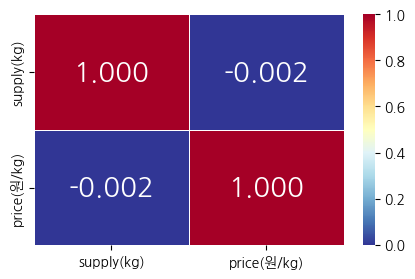

In [14]:
df = train_cy.corr()

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(5,3) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(df,
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            annot_kws = {'size' : 20},
            fmt= ".3f",
            # mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            # cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
           )  
plt.show()

In [15]:
train_df.location.value_counts()

location
J    35029
S    24368
Name: count, dtype: int64

In [16]:
train_df.corporation.value_counts()

corporation
A    13707
E    13707
D    12184
C     9138
B     7615
F     3046
Name: count, dtype: int64

* sypply, price 단변량 이변량 Ttest 확인 필

### 단변량

In [22]:
train_df_cy = train_df.copy()
train_df_cy['timestamp'] = pd.to_datetime(train_df_cy['timestamp'])
#df['date'].apply(lambda _ : datetime.strptime(_,'%Y%m%d'))
train_df_cy.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           59397 non-null  object        
 1   timestamp    59397 non-null  datetime64[ns]
 2   item         59397 non-null  object        
 3   corporation  59397 non-null  object        
 4   location     59397 non-null  object        
 5   supply(kg)   59397 non-null  float64       
 6   price(원/kg)  59397 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 3.2+ MB


In [23]:
train_df_cy.head()

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0


In [25]:
train_df_cy['year'] = train_df_cy['timestamp'].dt.year
train_df_cy['month'] = train_df_cy['timestamp'].dt.month
train_df_cy['days'] = train_df_cy['timestamp'].dt.day

In [26]:
train_df_cy.head(3)

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,days
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3


In [50]:
print(train_df_cy.columns)
numberic_col = ['supply(kg)','price(원/kg)']
categorical_col = ['item', 'corporation', 'year', 'month', 'days']

Index(['ID', 'timestamp', 'item', 'corporation', 'location', 'supply(kg)',
       'price(원/kg)', 'year', 'month', 'days'],
      dtype='object')


In [53]:
train_df_cy['supply(kg)']

0             0.0
1             0.0
2         60601.0
3         25000.0
4         32352.0
           ...   
59392    452440.0
59393    421980.0
59394    382980.0
59395    477220.0
59396    427520.0
Name: supply(kg), Length: 59397, dtype: float64

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

def kde_graph(df, target_list):
    target_len = len(target_list)
    plt.figure(figsize=(4*target_len, 5))
    if target_len <= 4:
        for index, target in enumerate(target_list):
            plt.subplot(1, target_len, index+1)
            sns.kdeplot(data=df, x=target)
            plt.title(target)
    else:
        for index, target in enumerate(target_list):
            plt.subplot((target_len // 4) + 1, 4, index+1)
            sns.kdeplot(data=df, x=target)
            plt.title(target)
    plt.tight_layout()
    plt.suptitle('Kde Plot')
    plt.show()


/home/stonedev/anaconda3/envs/Jeju/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/stonedev/anaconda3/envs/Jeju/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/stonedev/anaconda3/envs/Jeju/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/stonedev/anaconda3/envs/Jeju/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

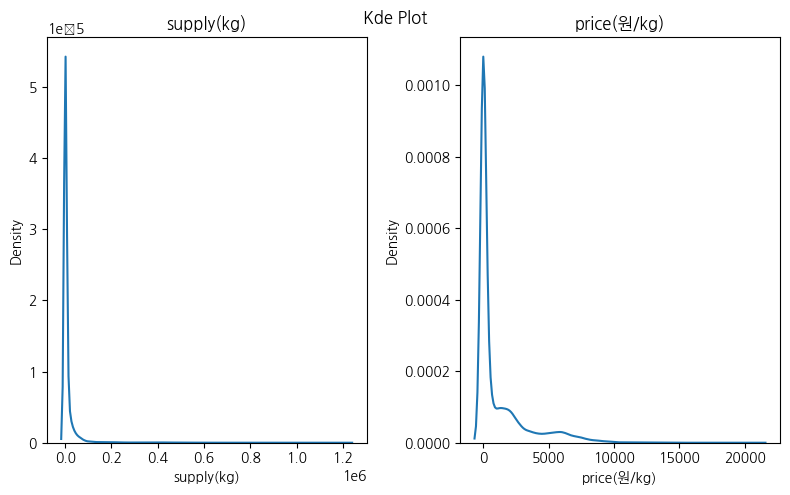

In [66]:
kde_graph(train_df_cy, numberic_col)

### 이변량

In [86]:
from itertools import combinations

def scatter_plots_with_hues(df, target_list, hue_list):
    # 가능한 모든 변수 쌍 생성
    variable_pairs = list(combinations(target_list, 2))
    
    # 각 변수 쌍에 대한 subplot 생성
    for x, y in variable_pairs:
        plt.figure(figsize=(5 * len(hue_list), 4))  # Adjust the figure size as needed
        
        for i, hue_col in enumerate(hue_list):
            plt.subplot(1, len(hue_list), i + 1)  # Create subplot in a single row
            sns.scatterplot(data=df, x=x, y=y, hue=hue_col)
            plt.title(f'{x} vs {y} | Hue: {hue_col}')
        
        plt.tight_layout()
        plt.show()


/home/stonedev/anaconda3/envs/Jeju/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/stonedev/anaconda3/envs/Jeju/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/stonedev/anaconda3/envs/Jeju/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/stonedev/anaconda3/envs/Jeju/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

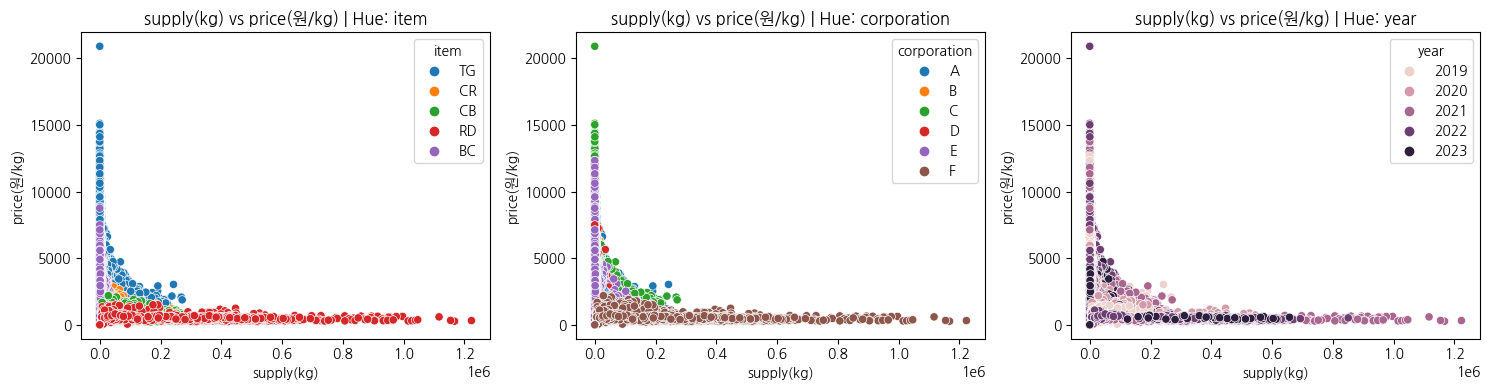

In [87]:
hue_col = ['item', 'corporation', 'year']
scatter_plots_with_hues(train_df_cy, numberic_col, hue_col)

----

### international_trade DataSet 

In [21]:
inter_df = pd.read_csv('../Jeju_product_price/data/international_trade.csv')

In [22]:
inter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274 entries, 0 to 1273
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   기간      1274 non-null   object
 1   품목명     1274 non-null   object
 2   수출 중량   1274 non-null   int64 
 3   수출 금액   1274 non-null   int64 
 4   수입 중량   1274 non-null   int64 
 5   수입 금액   1274 non-null   int64 
 6   무역수지    1274 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 69.8+ KB


In [23]:
inter_df.head(10)

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38
5,2019-01,양배추,184650,94,395802,90,4
6,2019-01,결구(結球) 상추,85200,95,258096,165,-70
7,2019-01,위트루프 치커리(Witloof chicory)[시코리엄 인티부스 변종 포리오섬(Ci...,0,0,90,1,-1
8,2019-01,당근,23150,22,7466150,2955,-2934
9,2019-01,오이류(신선한 것이나 냉장한 것으로 한정한다),10340,28,0,0,28


In [24]:
inter_df.tail(10)

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
1264,2023-02,감귤,6895,34,27765,98,-64
1265,2023-02,그레이프프루트(grapefruit)와 포멜로(pomelo),0,0,1175682,1856,-1856
1266,2023-02,레몬[시트러스 리몬(Citrus limon)ㆍ시트러스 리머늄(Citrus limon...,0,0,2037845,4238,-4238
1267,2023-02,수박,810,4,0,0,4
1268,2023-02,참외,14075,106,0,0,106
1269,2023-02,포포(papaw)[파파야(papaya)],0,0,23830,71,-71
1270,2023-02,사과,135165,351,0,0,351
1271,2023-02,배,2206012,5411,1,0,5411
1272,2023-02,신 체리[프루너스 체라서스(Prunus cerasus)],5,0,0,0,0
1273,2023-02,자두,0,0,2,0,0


In [25]:
inter_df.describe()

,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
count,1.274000e+03,1274.000000,1.274000e+03,1274.000000,1274.000000
mean,2.005844e+05,360.425432,1.255735e+06,1548.219780,-1187.789639
std,9.669554e+05,1689.359223,3.680257e+06,5844.805789,6171.655116
min,0.000000e+00,0.000000,0.000000e+00,0.000000,-84117.000000
25%,0.000000e+00,0.000000,0.000000e+00,0.000000,-1240.500000
50%,1.255000e+02,1.000000,2.926950e+04,89.500000,-61.500000
75%,1.556525e+04,31.000000,1.022696e+06,1253.000000,9.000000
max,2.094942e+07,16278.000000,4.975914e+07,84118.000000,16278.000000


In [26]:
inter_df.corr(numeric_only=True)

,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
수출 중량,1.000000,0.703511,-0.049525,-0.050148,0.240059
수출 금액,0.703511,1.000000,-0.066643,-0.054386,0.325233
수입 중량,-0.049525,-0.066643,1.000000,0.897462,-0.868172
수입 금액,-0.050148,-0.054386,0.897462,1.000000,-0.961923
무역수지,0.240059,0.325233,-0.868172,-0.961923,1.000000


In [27]:
corr = inter_df.select_dtypes('number').corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .format(precision=3)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_table_styles(magnify())

,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
수출 중량,1.000,0.704,-0.050,-0.050,0.240
수출 금액,0.704,1.000,-0.067,-0.054,0.325
수입 중량,-0.050,-0.067,1.000,0.897,-0.868
수입 금액,-0.050,-0.054,0.897,1.000,-0.962
무역수지,0.240,0.325,-0.868,-0.962,1.000


/home/stonedev/anaconda3/envs/Jeju/lib/python3.11/site-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/home/stonedev/anaconda3/envs/Jeju/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


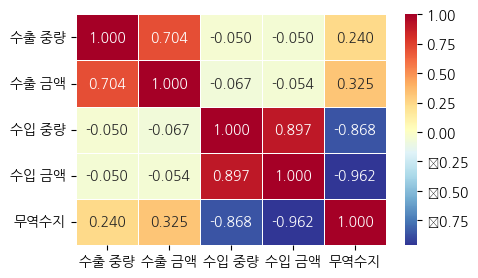

In [28]:
df = inter_df.corr(numeric_only=True)

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(5,3) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(df,
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            annot_kws = {'size' : 10},
            fmt= ".3f",
            # mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            # cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
           )  
plt.show()